# Лабараторная работа 1
Вариант 11

#### **Цель работы:**
Научиться реализовывать один из алгоритмов глубокого обучения.

#### **Задание:**
1. Скачайте датасет [CarDatasets](https://drive.google.com/drive/folders/1pkudEBabqbXMxRTgfGQs3e0VqfTjtqWU)
2. Реализуйте ResNet-101 с оптимизатором [Adabound](https://arxiv.org/abs/1902.09843v1) с использованием
Numpy и с **Torch**/Tensorflow/Jax
3. Оцените качество модели на тесте и сравните быстродействие
реализованных вариантов.
4. Запустить обучение на классическом Adam и сравнить сходимость
результатов с вариантом задания.
5. Сделайте отчёт в виде readme на GitHub, там же должен быть выложен
исходный код.

#### **Отчёт должен содержать следующие пункты:**
1. Теоретическая база
2. Описание разработанной системы (алгоритмы, принципы работы,
архитектура)
3. Результаты работы и тестирования системы (скриншоты, изображения,
графики, закономерности)
4. Выводы по работе
5. Использованные источники

План:
1. Получить Dataloader, возвращающий обрезанное в соответствии с annotations изображение, убедиться, что тензор корректно конвертируется в numpy
2. Загрузить и запустить готовый resnet101. Хотя, скорее всего, это не пригодится. Запустить на нём обучение
3. Имплементировать на torch
4. Имплементирвать на numpy


В датасете есть одноканальные изображения

In [1]:
import os
from collections import Counter
import pickle


import scipy.io
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score


from pytorch_nn.models.resnet import resnet101
from pytorch_nn.adabound import AdaBound

c:\Users\SystemPoint\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
torchvision.datasets.StanfordCars('.', split = "train", download = True)
torchvision.datasets.StanfordCars('.', split = "test", download = True)

In [6]:
# class ResizeToNeededHeight(torch.nn.Module):
    
#     def __init__(self, needed_height, interpolation=torchvision.transforms.InterpolationMode.BILINEAR, max_size=None, antialias=None):
#         super().__init__()
#         #_log_api_usage_once(self)
        
#         self.needed_height = needed_height
#         self.max_size = max_size

#         self.interpolation = interpolation
#         self.antialias = antialias

#     def forward(self, img):
#         """
#         Args:
#             img (PIL Image or Tensor): Image to be scaled.
#         Returns:
#             PIL Image or Tensor: Rescaled image.
#         """
#         w, h = img.size
#         size = (self.needed_height, round(w / h * self.needed_height))
#         return torchvision.transforms.functional.resize(
#             img, size, self.interpolation, self.max_size, self.antialias)

#     def __repr__(self) -> str:
#         detail = f"(needed_height={self.needed_height}, interpolation={self.interpolation.value}, max_size={self.max_size}, antialias={self.antialias})"
#         return f"{self.__class__.__name__}{detail}"


In [7]:

# class AddGaussianNoise(object):
#     def __init__(self, mean=0., std=1.):
#         self.std = std
#         self.mean = mean
        
#     def __call__(self, tensor):
#         return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
#     def __repr__(self):
#         return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


In [8]:
class CarsDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, classes = None, img_folder_path = '',
                 transform=None, target_transform=None):
        
        self.annotations = annotations
        self.transform = transform
        self.target_transform = target_transform
        self.img_folder_path = img_folder_path
        self.classes = classes

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        x1, y1, x2, y2, class_number, img_name = self.annotations[idx]
        uncropped_image = torchvision.io.read_image(
            os.path.join(self.img_folder_path, img_name))
        image = uncropped_image[:, y1:y2, x1:x2]
        #image = image.to(dtype = torch.float32)
        if image.shape[-3] == 1:
            image = torch.cat([image, image, image], dim=0)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_number = self.target_transform(class_number)
        return image, class_number - 1 # В аннтоациях числа от 1 до 196
    
# class CarsDatasetWithoutLabels(CarsDataset):
#     def __getitem__(self, idx):
#         x1, y1, x2, y2, img_name = self.annotations[idx]
#         uncropped_image = torchvision.io.read_image(
#             os.path.join(self.img_folder_path, img_name))
#         image = uncropped_image[:, y1:y2, x1:x2]
#         # image = image.to(dtype = torch.float32)
#         if self.transform:
#             image = self.transform(image)
#         return image


In [9]:
dataset_loc = r"./stanford_cars"

# annos['train'] и annos['val'] содержат x1, y1, x2, y2, class, img_name для каждого изображения датасета.
# class_names по индексу, равному числовому лейблу возвращает соответствующее имя класса
annos = dict()
annos['train'] = scipy.io.loadmat(
    os.path.join(r"./stanford_cars/devkit", 'cars_train_annos.mat'),
    squeeze_me = True
)['annotations']
annos['val'] = scipy.io.loadmat(
    os.path.join(dataset_loc, 'cars_test_annos_withlabels.mat'),
    squeeze_me = True
)['annotations']


class_names = scipy.io.loadmat(
    os.path.join(r"./stanford_cars/devkit", 'cars_meta.mat'),
    squeeze_me = True
)['class_names']

normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = dict()
data_transforms['train'] = (
    torchvision.transforms.Compose([
        # AddGaussianNoise(0.0,0.0000001),
        torchvision.transforms.ToPILImage(),
        #ResizeToNeededHeight(180),
        torchvision.transforms.RandomRotation((-13, 13)), # if you do rotation afterwords the quality will be worse
        torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
        #torchvision.transforms.RandomCrop(224, pad_if_needed=True),
        # torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.Resize((96, 96)),
        torchvision.transforms.RandomHorizontalFlip(p = 0.5),
        # torchvision.transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor(),
        # normalize
    ]))

data_transforms['val'] = (
    torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        # torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.Resize((96, 96)),
        #ResizeToNeededHeight(180),
        #torchvision.transforms.RandomCrop(224, pad_if_needed=True),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor(),
        # normalize
    ]))


folder_names = {
    "train": 'cars_train',
    "val": 'cars_test'
}


datasets = {
    phase: CarsDataset(annos[phase], img_folder_path = os.path.join(dataset_loc, folder_names[phase]), 
                       transform = data_transforms[phase], classes = class_names)
    for phase in ['train', 'val']
}



dataloaders = {
    'train':
    torch.utils.data.DataLoader(datasets['train'],
                                batch_size=200,# 512 - много # раньше 400 было норм
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'val':
    torch.utils.data.DataLoader(datasets['val'],
                                batch_size=200,
                                shuffle=False,
                                num_workers=0),  # for Kaggle
}

In [10]:
len(datasets['train']), len(datasets['val'])

(8144, 8041)

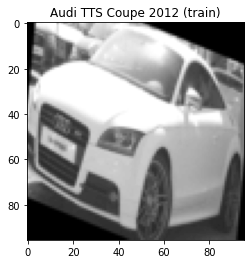

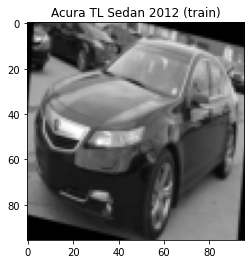

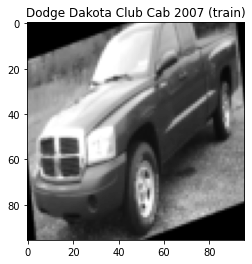

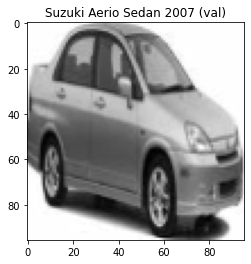

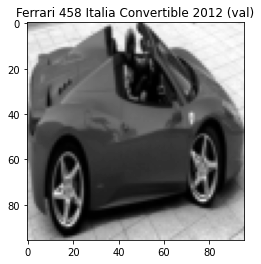

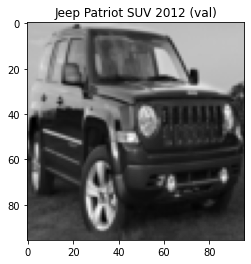

In [11]:
for phase in ['train', 'val']:
    for i in range(3):
        image, class_number = datasets[phase][i]
        plt.imshow(np.transpose(image, (1, 2, 0)), cmap='gray')
        plt.title(datasets[phase].classes[class_number]+ f' ({phase})')
        plt.show()

In [11]:
# This cell proves that there are imges with one channel

# min_h = 10000
# indexes_less_than_3_channels = []
# for i, (tensor, label) in enumerate(dataset_with_labels):
#     c, h, w = tensor.shape
#     min_h = min(h, min_h)
#     if c < 3:
#         indexes_less_than_3_channels.append(i)
#         if c != 1:
#             print(f"unexpected_number_of_channels: {c}")
# print(f"min_h = {min_h}")
# print(indexes_less_than_3_channels)

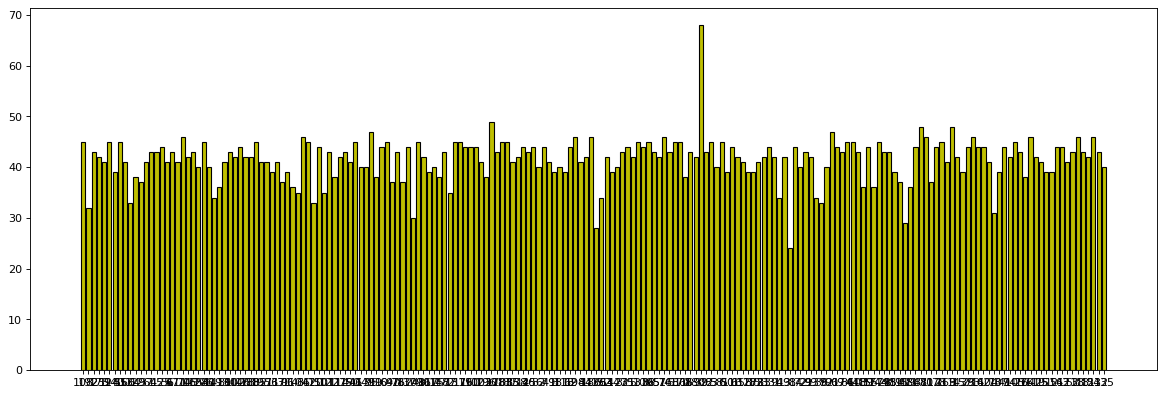

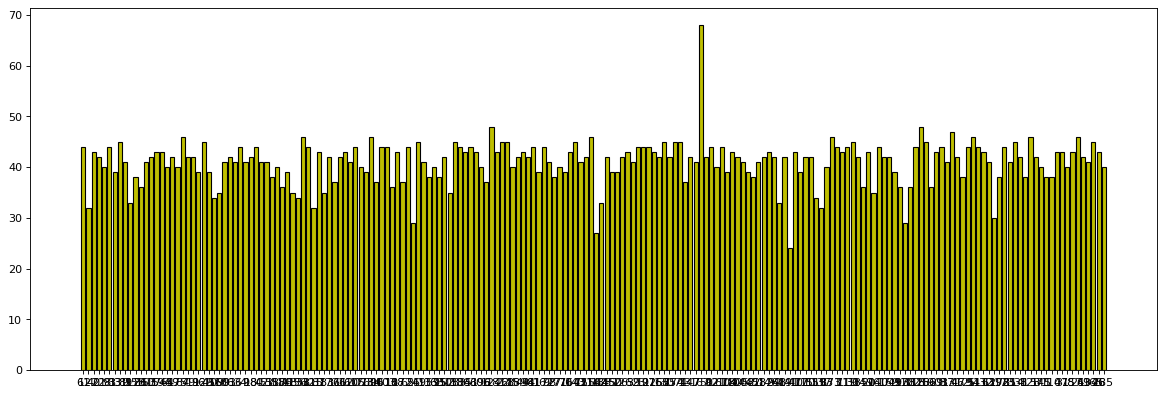

In [12]:
from collections import Counter

classes_train = [line[4] for line in annos['train']]
classes_val = [line[4] for line in annos['val']]

train_classes_count_dict = dict(Counter(classes_train))
val_classes_count_dict = dict(Counter(classes_val))
    
    
for value_counts in [train_classes_count_dict, val_classes_count_dict]:
    plt.figure(figsize=(40, 6), dpi=80)

    plt.subplot(1, 2, 1)
    plt.bar(
        x = value_counts.keys(),
        height = value_counts.values(),
        width = 0.8,
        align = 'center',
        color='y',
        edgecolor='k',
        tick_label=list(range(1, 197)),
        label = list(datasets['val'].classes))

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
n_classes = len(datasets['train'].classes)
n_classes

196

In [15]:
# !nvidia-smi

In [23]:
def train_model(model, criterion, optimizer, num_epochs=3, phases = ['train', 'val'], history = None):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)
    
        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            all_true_labels = []
            all_preds = []
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                all_true_labels.extend(labels.tolist())
                all_preds.extend(preds.tolist())

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.item() / len(datasets[phase])
            epoch_f_score = f1_score(all_true_labels, all_preds, average = 'macro')
            
            if history is not None:
                history[phase]["f_score"].append(epoch_f_score)
                history[phase]["loss"].append(epoch_loss)
                history[phase]["accuracy"].append(epoch_acc)

            # print(f"{phase} loss: {epoch_loss:.4f}, f_score: {epoch_f_score:.4f}")
            print(f"{phase} loss: {epoch_loss:.4f}, f_score: {epoch_f_score:.4f}, accuracy: {epoch_acc}")

In [24]:
def train_and_val(model, optimizer, history, experiment_name, n_train_epoches_in_iter = 4, n_iters = 2):
    criterion = torch.nn.CrossEntropyLoss()
    for i in range(n_iters):
        print(i)
        print("----------")
        train_model(model, criterion, optimizer, num_epochs=n_train_epoches_in_iter, phases = ['train'], history = history)
        
        n_epoches = len(history['train']['loss'])
        weights_name = f'{experiment_name}_{n_epoches}.h5'
        # weights_loc = os.path.join('.','pytorch_implementations','weights')
        weights_loc = '.'
        weights_path = os.path.join(weights_loc, weights_name)
        torch.save(model.state_dict(), weights_path)
        
        train_model(model, criterion, optimizer, num_epochs=1, phases = ['val'], history = history)

In [25]:
def plot_history(history1: dict, history2: dict):
    phases = ['train', 'val']
    fig, axs = plt.subplots(len(phases), len(history1['train']))

    fig.set_figheight(10)
    fig.set_figwidth(20)


    for phase_index, phase in enumerate(['train', 'val']):
        for key_index, (key, value) in enumerate(history1[phase].items()):
            axs[phase_index][key_index].plot(value)
            axs[phase_index][key_index].plot(history2[phase][key])
            axs[phase_index][key_index].set_title(f"{phase} {key}")
    plt.show()


In [26]:
my_resnet101 = resnet101(n_classes, 1).to(device)
weights_path = './my_resnet101_initialization.h5'
# torch.save(my_resnet101.state_dict(), './my_resnet101_initialization.h5')
my_resnet101.load_state_dict(torch.load(weights_path))

adabound_my_resnet = AdaBound(my_resnet101.parameters(), lr = 0.005)

my_resnet_history_AdaBound = {
    "train": {
        "loss": [],
        "f_score": [],
        "accuracy": [],
    },
    "val": {
        "loss": [],
        "f_score": [],
        "accuracy": [],
    }
} 

experiment_name = "my_torch_resnet_adabound"

In [27]:
train_and_val(my_resnet101, adabound_my_resnet, my_resnet_history_AdaBound, experiment_name, n_train_epoches_in_iter = 4, n_iters = 14)

0
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.48s/it]


train loss: 6.3782, f_score: 0.0012, accuracy: 0.004788801571709233
Epoch 2/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.48s/it]


train loss: 5.4266, f_score: 0.0003, accuracy: 0.004174852652259332
Epoch 3/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 5.3702, f_score: 0.0004, accuracy: 0.0069990176817288806
Epoch 4/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.48s/it]


train loss: 5.3449, f_score: 0.0004, accuracy: 0.008472495088408645
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.50s/it]


val loss: 5.4717, f_score: 0.0003, accuracy: 0.008456659619450317
1
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:05<00:00,  4.53s/it]


train loss: 5.3287, f_score: 0.0004, accuracy: 0.008104125736738703
Epoch 2/4
----------


100%|██████████| 41/41 [03:05<00:00,  4.51s/it]


train loss: 5.3046, f_score: 0.0002, accuracy: 0.007981335952848723
Epoch 3/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.3034, f_score: 0.0001, accuracy: 0.007735756385068762
Epoch 4/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.49s/it]


train loss: 5.3042, f_score: 0.0001, accuracy: 0.008104125736738703
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.51s/it]


val loss: 5.3628, f_score: 0.0001, accuracy: 0.008207934336525308
2
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 5.2870, f_score: 0.0002, accuracy: 0.007858546168958742
Epoch 2/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.2882, f_score: 0.0002, accuracy: 0.007981335952848723
Epoch 3/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 5.2859, f_score: 0.0003, accuracy: 0.008104125736738703
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.2780, f_score: 0.0001, accuracy: 0.008104125736738703
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.50s/it]


val loss: 5.2884, f_score: 0.0001, accuracy: 0.008456659619450317
3
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.2765, f_score: 0.0001, accuracy: 0.007981335952848723
Epoch 2/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.2753, f_score: 0.0001, accuracy: 0.008104125736738703
Epoch 3/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.2683, f_score: 0.0001, accuracy: 0.007981335952848723
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 5.2743, f_score: 0.0001, accuracy: 0.008226915520628684
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.49s/it]


val loss: 5.4074, f_score: 0.0003, accuracy: 0.008581022260912822
4
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 5.2718, f_score: 0.0001, accuracy: 0.008104125736738703
Epoch 2/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.2639, f_score: 0.0002, accuracy: 0.008226915520628684
Epoch 3/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.48s/it]


train loss: 5.2663, f_score: 0.0005, accuracy: 0.008226915520628684
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.2658, f_score: 0.0004, accuracy: 0.008718074656188604
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.50s/it]


val loss: 5.3409, f_score: 0.0003, accuracy: 0.008954110185300335
5
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 5.2592, f_score: 0.0005, accuracy: 0.008963654223968566
Epoch 2/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 5.2573, f_score: 0.0004, accuracy: 0.008840864440078585
Epoch 3/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 5.2528, f_score: 0.0004, accuracy: 0.009209233791748527
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 5.2521, f_score: 0.0006, accuracy: 0.01031434184675835
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.50s/it]


val loss: 5.2797, f_score: 0.0003, accuracy: 0.009700286034075363
6
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.2509, f_score: 0.0005, accuracy: 0.008963654223968566
Epoch 2/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.2467, f_score: 0.0010, accuracy: 0.011051080550098232
Epoch 3/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.2406, f_score: 0.0004, accuracy: 0.009700392927308447
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 5.2351, f_score: 0.0007, accuracy: 0.010928290766208252
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.51s/it]


val loss: 5.2513, f_score: 0.0004, accuracy: 0.011317000373087924
7
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.2273, f_score: 0.0006, accuracy: 0.011665029469548133
Epoch 2/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.49s/it]


train loss: 5.2185, f_score: 0.0006, accuracy: 0.01068271119842829
Epoch 3/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 5.2131, f_score: 0.0007, accuracy: 0.012033398821218075
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 5.2013, f_score: 0.0008, accuracy: 0.011173870333988213
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.50s/it]


val loss: 5.2891, f_score: 0.0002, accuracy: 0.009451560751150355
8
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.1948, f_score: 0.0010, accuracy: 0.012401768172888015
Epoch 2/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.1914, f_score: 0.0007, accuracy: 0.012278978388998035
Epoch 3/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 5.1849, f_score: 0.0005, accuracy: 0.011051080550098232
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.1860, f_score: 0.0009, accuracy: 0.012033398821218075
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.49s/it]


val loss: 5.3047, f_score: 0.0005, accuracy: 0.010570824524312896
9
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 5.1732, f_score: 0.0012, accuracy: 0.012770137524557957
Epoch 2/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.1711, f_score: 0.0014, accuracy: 0.012524557956777996
Epoch 3/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.48s/it]


train loss: 5.1714, f_score: 0.0010, accuracy: 0.011787819253438114
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.1748, f_score: 0.0008, accuracy: 0.011665029469548133
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.50s/it]


val loss: 5.2509, f_score: 0.0006, accuracy: 0.009949011317000373
10
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 5.1599, f_score: 0.0013, accuracy: 0.012033398821218075
Epoch 2/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 5.1588, f_score: 0.0008, accuracy: 0.011542239685658153
Epoch 3/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 5.1517, f_score: 0.0011, accuracy: 0.012524557956777996
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.1501, f_score: 0.0011, accuracy: 0.012647347740667976
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.50s/it]


val loss: 5.4006, f_score: 0.0009, accuracy: 0.011690088297475438
11
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 5.1526, f_score: 0.0019, accuracy: 0.013506876227897839
Epoch 2/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.49s/it]


train loss: 5.1516, f_score: 0.0011, accuracy: 0.011173870333988213
Epoch 3/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 5.1408, f_score: 0.0017, accuracy: 0.013261296660117878
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 5.1343, f_score: 0.0015, accuracy: 0.012156188605108056
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.51s/it]


val loss: 5.1955, f_score: 0.0009, accuracy: 0.01144136301455043
12
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 5.1337, f_score: 0.0018, accuracy: 0.013384086444007858
Epoch 2/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 5.1334, f_score: 0.0020, accuracy: 0.012770137524557957
Epoch 3/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.1263, f_score: 0.0017, accuracy: 0.013138506876227897
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 5.1158, f_score: 0.0024, accuracy: 0.0137524557956778
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.50s/it]


val loss: 5.2236, f_score: 0.0010, accuracy: 0.0106951871657754
13
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.1190, f_score: 0.0027, accuracy: 0.01387524557956778
Epoch 2/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 5.1118, f_score: 0.0026, accuracy: 0.014489194499017682
Epoch 3/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.1097, f_score: 0.0027, accuracy: 0.015225933202357564
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 5.1042, f_score: 0.0034, accuracy: 0.016331041257367385
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.50s/it]

val loss: 5.3844, f_score: 0.0020, accuracy: 0.01492351697550056


In [28]:
with open(f'{experiment_name}_history.pickle', 'wb') as f:
    pickle.dump(my_resnet_history_AdaBound, f)

with open(f'{experiment_name}_history.pickle', 'rb') as f:
    my_resnet_history_AdaBound = pickle.load(f)

adabound_optimizer_state_path = "./adabound_optimizer_state_my_resnet_101_40_epochs.h5"
torch.save(adabound_my_resnet.state_dict(), adabound_optimizer_state_path)

In [29]:
# experiment_name = "my_torch_resnet_adabound"
# with open(f'{experiment_name}_history.pickle', 'rb') as f:
#     my_resnet_history_AdaBound = pickle.load(f)

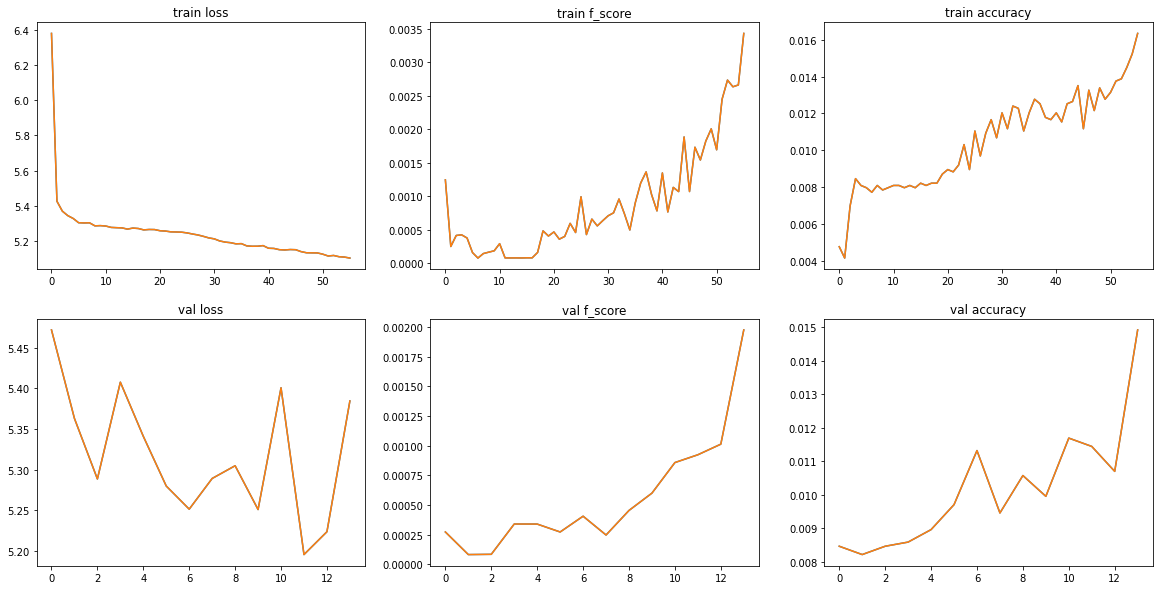

In [30]:
plot_history(my_resnet_history_AdaBound, my_resnet_history_AdaBound)

In [31]:
my_resnet101 = resnet101(n_classes, 1).to(device)
weights_path = './my_resnet101_initialization.h5'
# torch.save(my_resnet101.state_dict(), './my_resnet101_initialization.h5')
my_resnet101.load_state_dict(torch.load(weights_path))

adam_my_resnet = torch.optim.Adam(my_resnet101.parameters(), lr = 0.005)

my_resnet_history_Adam = {
    "train": {
        "loss": [],
        "f_score": [],
        "accuracy": [],
    },
    "val": {
        "loss": [],
        "f_score": [],
        "accuracy": [],
    }
} 

experiment_name = "my_torch_resnet_adam"

In [32]:
train_and_val(my_resnet101, adam_my_resnet, my_resnet_history_Adam, experiment_name, n_train_epoches_in_iter = 4, n_iters = 14)

0
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 6.4147, f_score: 0.0007, accuracy: 0.004788801571709233
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 5.2787, f_score: 0.0006, accuracy: 0.0068762278978389
Epoch 3/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 5.2745, f_score: 0.0002, accuracy: 0.007981335952848723
Epoch 4/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.46s/it]


train loss: 5.2706, f_score: 0.0008, accuracy: 0.009700392927308447
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.49s/it]


val loss: 5.2657, f_score: 0.0005, accuracy: 0.009202835468225345
1
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 5.2645, f_score: 0.0004, accuracy: 0.007858546168958742
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 5.2538, f_score: 0.0002, accuracy: 0.007858546168958742
Epoch 3/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.48s/it]


train loss: 5.2415, f_score: 0.0012, accuracy: 0.009577603143418467
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 5.2307, f_score: 0.0009, accuracy: 0.009086444007858546
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.51s/it]


val loss: 5.2203, f_score: 0.0006, accuracy: 0.010446461882850392
2
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 5.2125, f_score: 0.0008, accuracy: 0.009454813359528488
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 5.2060, f_score: 0.0011, accuracy: 0.01043713163064833
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 5.1877, f_score: 0.0012, accuracy: 0.011787819253438114
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 5.1737, f_score: 0.0022, accuracy: 0.012647347740667976
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 5.2945, f_score: 0.0015, accuracy: 0.012436264146250466
3
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 5.1592, f_score: 0.0024, accuracy: 0.014980353634577602
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 5.1379, f_score: 0.0032, accuracy: 0.014980353634577602
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.44s/it]


train loss: 5.1241, f_score: 0.0039, accuracy: 0.014857563850687623
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 5.1605, f_score: 0.0034, accuracy: 0.012892927308447938
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.50s/it]


val loss: 5.1647, f_score: 0.0026, accuracy: 0.014052978485263027
4
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.48s/it]


train loss: 5.1013, f_score: 0.0037, accuracy: 0.014611984282907662
Epoch 2/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.48s/it]


train loss: 5.0730, f_score: 0.0057, accuracy: 0.017804518664047152
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 5.0554, f_score: 0.0050, accuracy: 0.018050098231827114
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 5.0341, f_score: 0.0050, accuracy: 0.01706777996070727
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 5.0756, f_score: 0.0057, accuracy: 0.019151846785225718
5
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.43s/it]


train loss: 5.0157, f_score: 0.0065, accuracy: 0.020260314341846757
Epoch 2/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.46s/it]


train loss: 4.9972, f_score: 0.0093, accuracy: 0.022716110019646366
Epoch 3/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.48s/it]


train loss: 4.9627, f_score: 0.0121, accuracy: 0.025785854616895875
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.44s/it]


train loss: 4.8994, f_score: 0.0137, accuracy: 0.030206286836935166
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 5.0032, f_score: 0.0088, accuracy: 0.021763462255938316
6
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 4.8036, f_score: 0.0184, accuracy: 0.036468565815324164
Epoch 2/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.43s/it]


train loss: 4.7069, f_score: 0.0231, accuracy: 0.03953831041257368
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 4.5704, f_score: 0.0325, accuracy: 0.04776522593320236
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.44s/it]


train loss: 4.4506, f_score: 0.0406, accuracy: 0.05550098231827112
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.49s/it]


val loss: 4.7958, f_score: 0.0247, accuracy: 0.043278199228951625
7
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.42s/it]


train loss: 4.3044, f_score: 0.0504, accuracy: 0.06593811394891945
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 4.1742, f_score: 0.0582, accuracy: 0.07391944990176817
Epoch 3/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 4.0502, f_score: 0.0781, accuracy: 0.09344302554027505
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 3.8761, f_score: 0.0926, accuracy: 0.10903732809430255
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.50s/it]


val loss: 4.5776, f_score: 0.0586, accuracy: 0.08319860713841562
8
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.46s/it]


train loss: 3.7288, f_score: 0.1149, accuracy: 0.1300343811394892
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 3.5262, f_score: 0.1394, accuracy: 0.15582023575638507
Epoch 3/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 3.3753, f_score: 0.1644, accuracy: 0.17841355599214145
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 3.2032, f_score: 0.1944, accuracy: 0.20640962671905697
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 3.9735, f_score: 0.1364, accuracy: 0.1520955105086432
9
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 2.9960, f_score: 0.2362, accuracy: 0.24791257367387035
Epoch 2/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 2.7954, f_score: 0.2749, accuracy: 0.28303045186640474
Epoch 3/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.48s/it]


train loss: 2.6934, f_score: 0.2963, accuracy: 0.3037819253438114
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 2.4740, f_score: 0.3359, accuracy: 0.343565815324165
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 3.7090, f_score: 0.1930, accuracy: 0.21912697425693323
10
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 2.3547, f_score: 0.3744, accuracy: 0.3800343811394892
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 2.2003, f_score: 0.3954, accuracy: 0.4011542239685658
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.44s/it]


train loss: 2.0055, f_score: 0.4440, accuracy: 0.44855108055009824
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 1.8467, f_score: 0.4828, accuracy: 0.487475442043222
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 3.0085, f_score: 0.2901, accuracy: 0.30580773535629896
11
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 1.6953, f_score: 0.5213, accuracy: 0.524680746561886
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 1.5342, f_score: 0.5546, accuracy: 0.5567288801571709
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 1.4348, f_score: 0.5842, accuracy: 0.5854616895874263
Epoch 4/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.44s/it]


train loss: 1.3192, f_score: 0.6097, accuracy: 0.6108791748526523
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.49s/it]


val loss: 2.5139, f_score: 0.4112, accuracy: 0.41524685984330306
12
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.44s/it]


train loss: 1.1874, f_score: 0.6482, accuracy: 0.6488212180746562
Epoch 2/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 1.0805, f_score: 0.6784, accuracy: 0.6793958742632613
Epoch 3/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.46s/it]


train loss: 0.9989, f_score: 0.6974, accuracy: 0.6969548133595285
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 0.8890, f_score: 0.7346, accuracy: 0.7340373280943026
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 2.2936, f_score: 0.4606, accuracy: 0.4616341251088173
13
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.44s/it]


train loss: 0.8288, f_score: 0.7500, accuracy: 0.75036836935167
Epoch 2/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.44s/it]


train loss: 0.7346, f_score: 0.7731, accuracy: 0.7734528487229863
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 0.6946, f_score: 0.7911, accuracy: 0.7906434184675835
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 0.5938, f_score: 0.8168, accuracy: 0.8169204322200393
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]

val loss: 2.7928, f_score: 0.4383, accuracy: 0.4428553662479791


In [33]:
with open(f'{experiment_name}_history.pickle', 'wb') as f:
    pickle.dump(my_resnet_history_Adam, f)

with open(f'{experiment_name}_history.pickle', 'rb') as f:
    my_resnet_history_Adam = pickle.load(f)

adam_optimizer_state_path = "./adam_optimizer_state_my_resnet_101_40_epochs.h5"
torch.save(adam_my_resnet.state_dict(), adam_optimizer_state_path)

In [34]:
# experiment_name = "my_torch_resnet_adam"
# with open(f'{experiment_name}_history.pickle', 'rb') as f:
#     my_resnet_history_Adam = pickle.load(f)

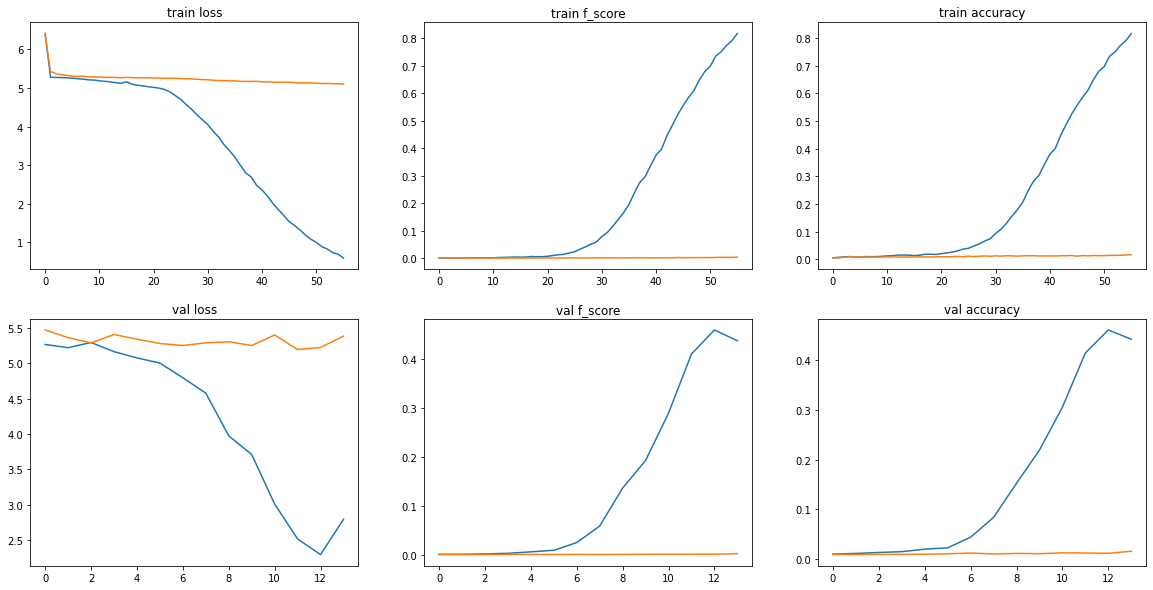

In [36]:
plot_history(my_resnet_history_Adam, my_resnet_history_AdaBound)